In [1]:
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import pandas as pd
import random
from itertools import combinations
import hashlib
from scipy import stats

## Тестовый стенд для проверки устойчивости критериев 


**Для этого введем следующий фреймворк:**  

1️⃣ Введем `test_test` — это функция тестового стенда, которой мы передаем на вход критерий (`test_function` — например, критерий Стьюдента) и два метода генерации выборки (`array_function1`, `array_function2`), средние которых мы сравниваем при помощи критерия из `test_function`. Функцией `test_test` мы будем воспроизводить многократное проведение экспериментов в разных условиях.    

2️⃣ При многократном применении функции `test_test` получим распределение p-value для конкретных условий. В идеальном случае у p-value распределение равномерное.  

3️⃣ Если p-value распределено равномерно, мы сможем сделать вывод о том, что результат применения критерия совпадает с нашими теоретическими ожиданиями. Например, при проведении 1000 экспериментов для случайных величин, между которыми на самом деле нет различий при $\alpha$=5% мы зафиксируем ложное отклонение на 50 экспериментов (там, где его нет на самом деле — а это ошибка I рода).


Запишем функцию критерия, который будем тестировать:

In [24]:
def test_test(test_function, array_function1, array_function2): 
    tmp_array = []
    for i in range(5000):
        x1 = array_function1() #функции, которые получаем в выборке для тестирования критериев
        x2 = array_function2()
        tmp_array.append(test_function(x1,x2))
    return np.array(tmp_array)

Запишем функцию `normal_smp`, которая собирает случайную выборку из нормального распределения, и функцию t-теста (`ttest`):

In [46]:
def normal_smp(): 
    return np.random.normal(100,10,1000)

def normal_smp1(): 
    return np.random.normal(102,10,1000)

def ttest(x1,x2): 
    return stats.ttest_ind(x1,x2)[1]

In [29]:
x1 = np.random.normal(100,10,10)
x2 = np.random.normal(110,10,10)

In [31]:
x2

array([102.46433402, 110.26966357, 115.18126227, 113.69120256,
       115.01793177, 118.1684997 ,  98.49919675, 103.32386405,
       128.77886738, 105.03935097])

In [10]:
stats.ttest_ind(x1,x2)

Ttest_indResult(statistic=1.8924244105996573, pvalue=0.058578893537287194)

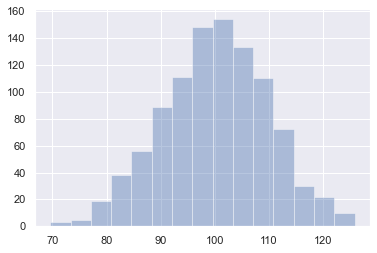

In [9]:
sns.distplot(normal_smp(), bins=15,hist=True, kde=False) #распределение выборки из нормального распределения

Поскольку наша случайная выборка была взята нормального распределения — неудивительно, что по графику она распределена нормально.

In [47]:
p_vaule_array = test_test(ttest,normal_smp,normal_smp1)

In [51]:
1-p_vaule_array[p_vaule_array>=0.001].shape[0]/p_vaule_array.shape[0]

0.882

In [ ]:
p

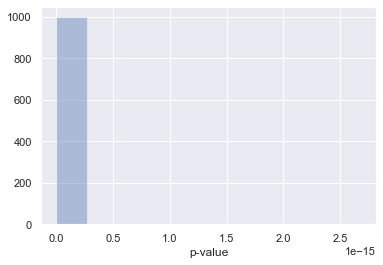

In [45]:
sns.distplot(p_vaule_array, bins=10,hist=True, kde=False,axlabel='p-value') #распределение t-теста

In [6]:
stats.binomtest(p_vaule_array[p_vaule_array<0.05].shape[0], n=1000, p=0.05, alternative='two-sided')

BinomTestResult(k=35, n=1000, alternative='two-sided', proportion_estimate=0.035, pvalue=0.029150364117893672)

In [22]:
stats.binomtest(14, n=16, p=0.5, alternative='greater')

BinomTestResult(k=14, n=16, alternative='greater', proportion_estimate=0.875, pvalue=0.0020904541015625)

In [24]:
x1 = [0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1]
x2 = [0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1]

stats.ttest_ind(x1,x2)

Ttest_indResult(statistic=-2.4227185592617446, pvalue=0.021652517893688356)

In [28]:
(np.mean(x2)-1/2)/((16*0.5*0.5)/4)

0.375

In [ ]:
ST1=(M - avg1)/sigma
ST2=(M - avg2)/sigma

0-(avg1 - avg2)/sigma(avg1 - avg2)

☝️ Распределение t-теста равномерно, в отличие от предыдущего графика.  

## Зависимости в выборках

Рассмотрим интересный пример из производства.  

> 📊 **Пример**  
Мы провели эксперимент с оптимизацией производственного процесса.  
На графике представлен выход продукта в зависимости от дня.  
В первые 10 дней проводился эксперимент с условиями A, вторые 10 дней проводился эксперимент с условиями B.

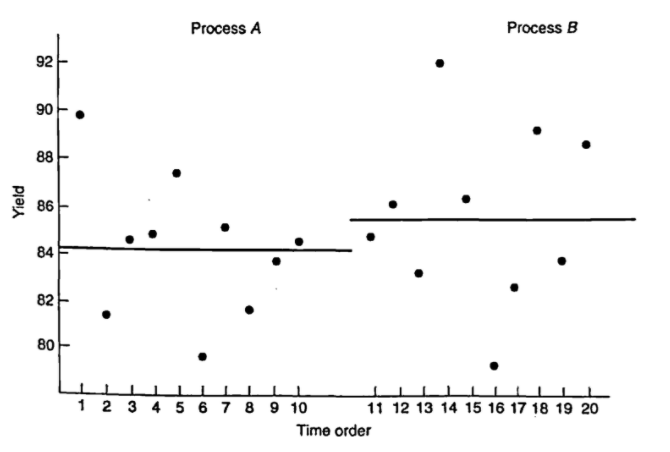

Получили средние в группах:  

${\overline y}_A=84.24$  
${\overline y}_B=85.54$  
${\overline y}_A-{\overline y}_B=1.30$  


**Является ли это отклонение статистически значимым?**  

Итак, сначала оценим p-value наивным методом, а потом — с помощью t-testa.  

У нас есть предыдущая история по выходу продукта за 210 дней.
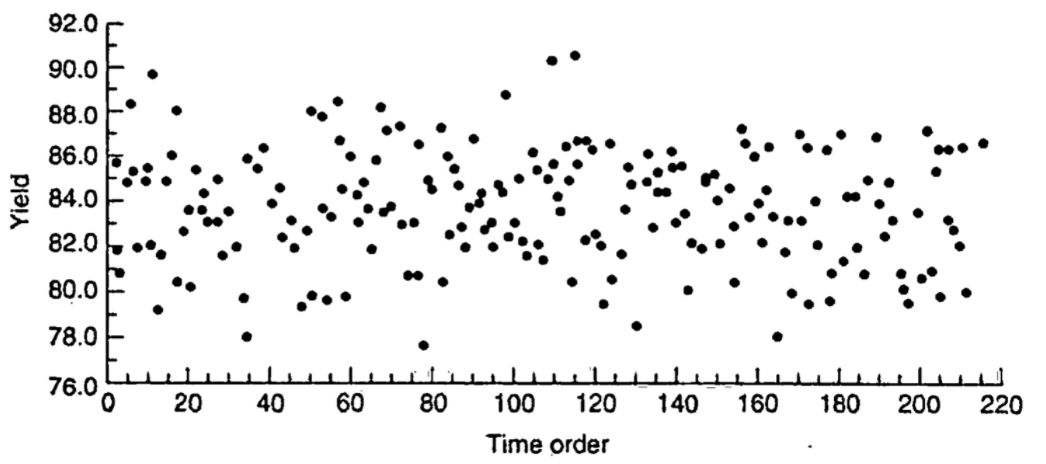

Возьмем первые 10 дней из 191 дня наблюдений.  
1) Сравним выход за эти 10 дней с выходом за следующие 10 дней. Различия между ними отметим на графике.   
2) Дальше сделаем шаг вперед на один день: возьмем новые 10 дней, включающие 9 дней из предыдущей десятки и еще один последующий день. Снова сравним выход за эти 10 дней и за следующие 10 дней и отметим на графике.  
3) Будем делать так, пока не закончится время эксперимента (последнее сравнение будет: 172-181 сравниваем с 182-191).  

👉 Полученный набор различий в выходе обеспечивает эталон, с которым можно сравнить наблюдаемую разницу в 1.30. Довольно редко, а именно только в девяти случаях, различия в эталонной таблице превышают 1.30.  

Если значение p-value меньше 0.05, то мы сможем сделать вывод о случайных вариациях в процессе.  

> *Применив наивный критерий на основе распределения выхода продукта, когда к нему не применены другие условия, получили p-value на уровне 4%=9/191*   
  
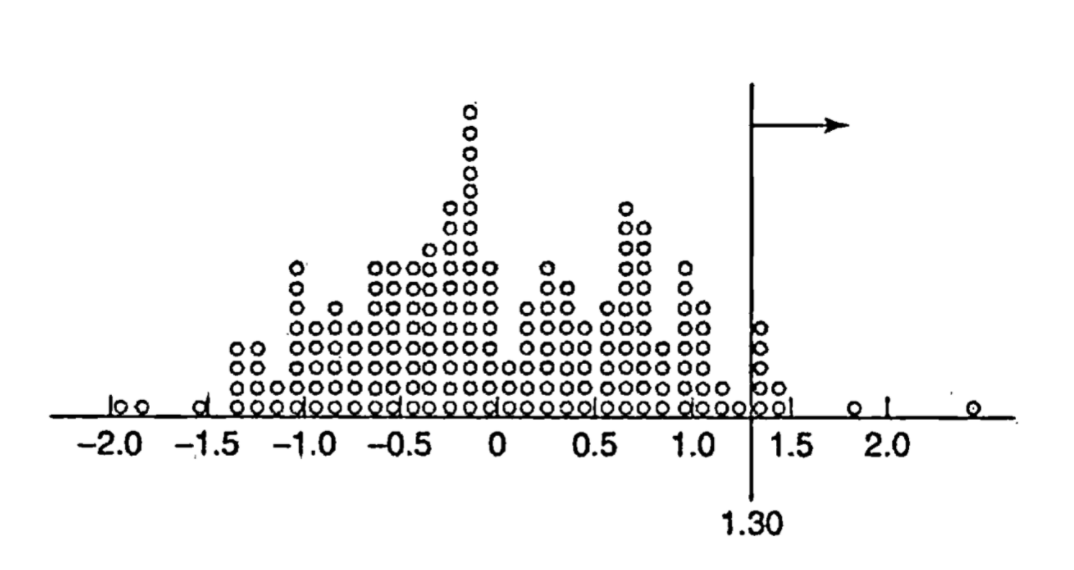

👉 Такое p-value = 4%


> 💬 В данных всегда могут присутствовать явные и неявные взаимозависимости, которые, в разной степени, влияют на качество применения критериев.
<br> Результаты применения критериев, т.е. p-value, стремятся к реальной вероятности ошибки I рода. На практике p-value можно интерпретировать как силу отклонения одной группы от другой.  
 
📌 **Интерпретация p-value:**  
**p-value=0.001** — это сильно значимое отклонение.  
**p-value=0.01** — среднее по степени значимости отклонение, при таком отклонении нужно лучше понимать причины, которые к нему привели.   
**p-value=0.05** — это потенциально серая зона и такой результат применения критерия говорит о том, что на отклонение надо обратить внимание, но делать выводы исключительно по нему нельзя.

Из этого примера мы поняли, что для выборок, подверженных автокорреляции, t-test может давать p-value, сильно отличающийся от истинного. Это приведет аналитика к неверным выводам.  

👉 Решениями могут быть:  
1) использование специфических методов, созданных специально для работы с автокорреляцией, позволяющих либо избавиться от автокорреляции, либо моделировать ее. Подробнее это разбиралось в 9 занятии курса по эконометрике (ААА).   
2) изменение дизайна эксперимента для полного устранения или снижения автокорреляции, чтобы получилось использовать простые критерии (например, t-test).  

## Проблема подбора длины и подглядывания

Использовать результаты эксперимента до его окончания или продление эксперимента до получения статистической значимости приводит к **завышению значимости** в тесте.


💬 В процессе проведения эксперимента достаточно часто встречается такая ошибка, когда исследователь раньше срока начинает наблюдать статзначимое отклонение и решает его остановить или наоборот, когда в запланированный срок не получается статзначимое отклонение, и исследователь решает подержать ещё. Использовать результаты эксперимента до его окончания или продление эксперимента до получения статистической значимости приводит к завышению значимости.  


Дополнительно о завышении значимости теста можно посмотреть в [этой статье](https://www.lucidchart.com/blog/the-fatal-flaw-of-ab-tests-peeking).   

👉 Завышение значимости приводит к тому, что в некоторых случаях мы будем признавать отклонения в тех моментах, когда их нет, то есть на самом деле ошибка I рода будет выше, чем мы полагаем.  


Эмулируем нашу ситуацию:

In [38]:
#t= a + b

n_tests=500
def test_time(test_function, array_function, alpha):
    tmp_array = []
    for i in range(n_tests):
        
        xa_1 = array_function()
        xa_2 = array_function()
        
        xt_1 = xa_1 + array_function() #имитируем ситуацию когда ждём ещё
        xt_2 = xa_2 + array_function()
        
        ta = test_function(xa_1,xa_2) #применяем t-тест для первой и второй выборки отдельно
        tt = test_function(xt_1,xt_2)
        if ta<alpha/5: # если p-value оказался ниже альфа, то останавливаем эксперимент
            tmp_array.append(ta)
        else:    
            tmp_array.append(tt)
            
   
    return np.array(tmp_array)

def normal_smp():
    return np.random.normal(100,10,100)

def ttest(x1,x2):
    return stats.ttest_ind(x1,x2)[1]

In [39]:
p_vaule_array=test_time(ttest, normal_smp, 0.05)

Теперь посмотрим на распределение значений p-value в имитируемом нами тесте:

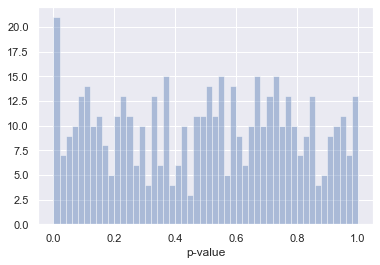

In [40]:
sns.distplot(p_vaule_array, bins=50,hist=True, kde=False,axlabel='p-value') 

In [41]:
stats.binomtest(p_vaule_array[p_vaule_array<0.05].shape[0], n=n_tests, p=0.05, alternative='two-sided')

BinomTestResult(k=32, n=500, alternative='two-sided', proportion_estimate=0.064, pvalue=0.1503660433797932)

☝️ Получили график распределения p-value. По идее, распределение должно было получиться равномерным, так как у нас не было отклонений и t-тест должен был быть ровным, но на практике ситуация иная. Разберемся далее, почему так вышло.

## Выбросы

> 📌**Выброс** — результат измерения, не попадающий под общее распределение.

Часто в выборку попадают очень не типичные её представители:

- Боты
- Power пользователи
 

Давайте рассмотрим эту ситуацию на примере.  

* Создадим две выборки из нормального распределения с параметрами (100, 10) размером 100 наблюдений каждая. 
При этом добавим в обе выборки по два наблюдения-выброса из равномерного распределения. В первую выборку будем добавлять выбросы из полуинтервала \[50,170), а во вторую — из полуинтервала \[160,180).  

* Таким образом, полученные выборки различаются только выбросами, которые составляют 2% (2 из 102).   
* Посмотрим, приведут ли эти 2% выброса к нарушению результатов `t-testа`. Для этого проведем сравнение выборок, полученных из таких СВ, с помощью `t-testa` 1000 раз (используя написанный нами ранее `test_test`).   
* Если бы выбросов не было, мы бы получили равномерное распределение p-value на этой выборке из 1000 повторений.  

Посмотрим, какой результат мы получим с выбросами.   

`Np.random.randint` — это стандартная функция по генерации случайного целого из равномерного распределения (полуинтервала). Первые два параметра — это полуинтервал, из которого нужно выбрать случайные числа в количестве, равном значению третьего параметра. 

In [6]:
def normal_smp1():
    return np.random.normal(100,10,100)

def normal_smp2():
    return np.random.normal(100,10,100)def normal_smp1():
    return np.hstack((np.random.normal(100,10,100),np.random.randint(50,200,2)))

def normal_smp2():
    return np.hstack((np.random.normal(100,10,100),np.random.randint(50,200,2)))

def ttest(x1,x2):
    return stats.ttest_ind(x1,x2)[1]

In [43]:
def normal_smp1():
    return np.random.normal(100,10,100)

def normal_smp2():
    return np.random.normal(100,10,100)


def normal_smp1():
    return np.hstack((np.random.normal(100,10,100),np.random.randint(110,171,1)))

def normal_smp2():
    return np.hstack((np.random.normal(100,10,100),np.random.randint(110,171,1)))



def ttest(x1,x2):
    return stats.ttest_ind(x1,x2)[1]



p_vaule_array =test_test(ttest,normal_smp1,normal_smp2)
stats.binomtest(p_vaule_array[p_vaule_array<0.05].shape[0], n=5000, p=0.05, alternative='two-sided')

BinomTestResult(k=184, n=5000, alternative='two-sided', proportion_estimate=0.0368, pvalue=8.60178407138655e-06)

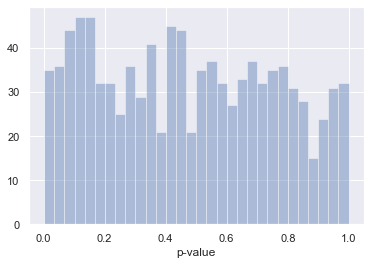

In [4]:
sns.distplot(test_test(ttest,normal_smp1,normal_smp2), bins=30,hist=True, kde=False,axlabel='p-value')

Видим, что полученное распределение p-value менее равномерно, чем могло быть без выбросов.  
💬 *Проверим, убрав выбросы, и посмотрим, что получится :)* 

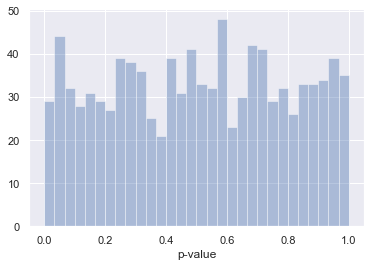

In [12]:
def normal_smp1():
    return (np.random.normal(100,10,100))

def normal_smp2():
    return (np.random.normal(100,10,100))

def ttest(x1,x2):
    return stats.ttest_ind(x1,x2)[1]

sns.distplot(test_test(ttest,normal_smp1,normal_smp2), bins=30,hist=True, kde=False,axlabel='p-value')

Теперь посмотрим на следующую ситуацию: разница между выборками существует, но наличие 5% выбросов в выборке приводит к занижению значимости:

In [48]:
def normal_smp1():
    return np.hstack((np.random.normal(105,10,100),np.random.randint(150,180,5)))

def normal_smp2():
    return np.hstack((np.random.normal(100,10,100),np.random.randint(150,180,5)))

def ttest(x1,x2):
    return stats.ttest_ind(x1,x2)[1]

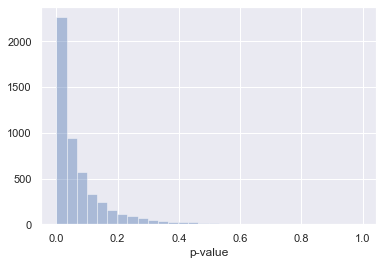

In [49]:
sns.distplot(test_test(ttest,normal_smp1,normal_smp2), bins=30,hist=True, kde=False,axlabel='p-value')

In [50]:
def ttest(x1,x2):
    return stats.ttest_ind(x1[x1<np.quantile(x1,0.95)],x2[x2<np.quantile(x2,0.95)])[1]

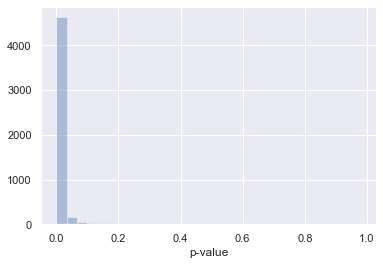

In [51]:
sns.distplot(test_test(ttest,normal_smp1,normal_smp2), bins=30,hist=True, kde=False,axlabel='p-value')

## Бакеты

In [117]:
def get_bucket(num):
    return (int(hashlib.sha256(str(num).encode('utf-8')).hexdigest(), 16)%10**8)%50

In [113]:
d=pd.read_csv('banner_conversion.csv')

In [114]:
d.head(10)

,index,test_group,imps,clicks
0,0,control,75.0,2.0
1,1,control,100.0,2.0
2,2,control,74.0,2.0
3,3,control,99.0,2.0
4,4,control,70.0,1.0
5,5,control,84.0,2.0
6,6,control,90.0,2.0
7,7,control,118.0,3.0
8,8,control,109.0,2.0
9,9,control,64.0,1.0


/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


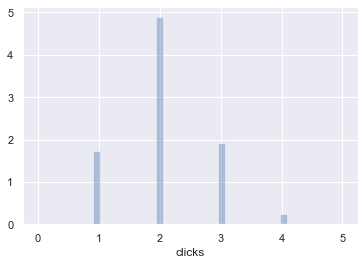

In [115]:
sns.distplot(d.clicks)

In [118]:
d['bucket']=d['index'].apply(get_bucket)

In [119]:
d_gr = d.groupby(['bucket','test_group']).sum()[['imps','clicks']].reset_index()

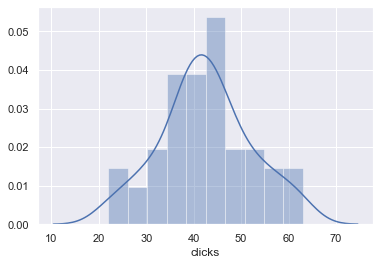

In [120]:
sns.distplot(d_gr[(d_gr.test_group=='test')].clicks,bins=10,hist=True,)

## RATIO-метрики

In [4]:
d=pd.read_csv('banner_conversion.csv')

Разделим данные на бакеты:

In [121]:
d_gr = d.groupby(['bucket','test_group']).sum()[['imps','clicks']].reset_index()
d_gr['ctr'] = d_gr.clicks/d_gr.imps
control = d_gr[(d_gr.test_group=='control')]
test = d_gr[(d_gr.test_group=='test')]

Посмотрим t-статистику по кликам (*clicks*) и CTR (*ctr*):

In [122]:
stats.ttest_ind(control.imps,test.imps) 

Ttest_indResult(statistic=0.09561721708562006, pvalue=0.9240198412950313)

In [123]:
stats.ttest_ind(control.clicks,test.clicks) 

Ttest_indResult(statistic=-0.8906514420113578, pvalue=0.37529756666188185)

In [124]:
stats.ttest_ind(control.ctr,test.ctr)

Ttest_indResult(statistic=-3.5044771040894016, pvalue=0.0006913691127765975)

У *ctr* p-value ниже, что показывает большую чувствительность этой метрики к изменениям.  
